In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns

# Import raw files

In [2]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [3]:
PJ048 = sc.read(inpath+"PJ048.h5ad")
PJ030 = sc.read(inpath+"PJ030.h5ad")
PJ025 = sc.read(inpath+"PJ025.h5ad")
PJ018 = sc.read(inpath+"PJ018.h5ad")
PJ017 = sc.read(inpath+"PJ017.h5ad")
PJ016 = sc.read(inpath+"PJ016.h5ad")

# Read Metadata

In [4]:
metadata = pd.read_excel('Metadata2.xlsx')

# Fix Metadata 

In [5]:
tmp1 = metadata.loc[metadata['SampleID'] == "PJ048"].loc[metadata.loc[metadata['SampleID'] == "PJ048"].index.repeat(PJ048.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "PJ048-" + tmp1.index.astype(str),inplace=True) 
PJ048.obs = tmp1

In [6]:
tmp1 = metadata.loc[metadata['SampleID'] == "PJ030"].loc[metadata.loc[metadata['SampleID'] == "PJ030"].index.repeat(PJ030.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "PJ030-" + tmp1.index.astype(str),inplace=True) 
PJ030.obs = tmp1

In [7]:
tmp1 = metadata.loc[metadata['SampleID'] == "PJ025"].loc[metadata.loc[metadata['SampleID'] == "PJ025"].index.repeat(PJ025.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "PJ025-" + tmp1.index.astype(str),inplace=True) 
PJ025.obs = tmp1

In [8]:
tmp1 = metadata.loc[metadata['SampleID'] == "PJ018"].loc[metadata.loc[metadata['SampleID'] == "PJ018"].index.repeat(PJ018.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "PJ018-" + tmp1.index.astype(str),inplace=True) 
PJ018.obs = tmp1

In [9]:
tmp1 = metadata.loc[metadata['SampleID'] == "PJ017"].loc[metadata.loc[metadata['SampleID'] == "PJ017"].index.repeat(PJ017.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "PJ017-" + tmp1.index.astype(str),inplace=True) 
PJ017.obs = tmp1

In [10]:
tmp1 = metadata.loc[metadata['SampleID'] == "PJ016"].loc[metadata.loc[metadata['SampleID'] == "PJ016"].index.repeat(PJ016.shape[0])]
tmp1.reset_index(drop=True,inplace=True)
tmp1.set_index( "PJ016-" + tmp1.index.astype(str),inplace=True) 
PJ016.obs = tmp1

# Concatenate 

In [11]:
adata = PJ048.concatenate(PJ030,PJ025, PJ018, PJ017, PJ016,index_unique=None)

In [12]:
del(PJ048, PJ030,PJ025, PJ018, PJ017, PJ016)

In [13]:
print(adata.obs['SampleID'].value_counts())
adata

PJ025    5924
PJ030    3097
PJ016    3085
PJ048    3084
PJ018    2197
PJ017    1261
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 18648 × 49774
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'

In [14]:
adata.layers['raw'] = adata.X 

# Calculate QC

In [15]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [16]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [17]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [18]:
adata

AnnData object with n_obs × n_vars = 18648 × 49774
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw'

# Plot QC

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


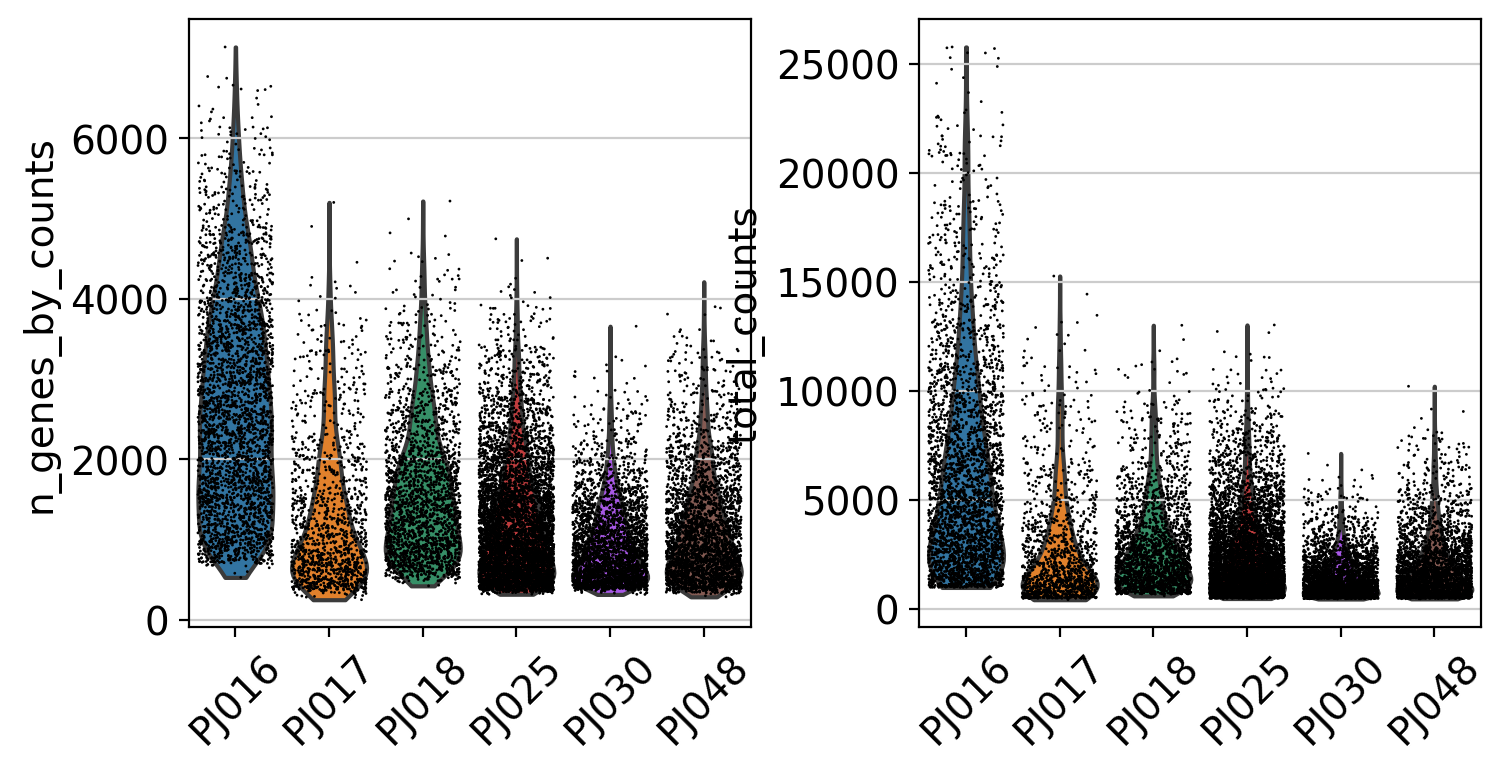

In [19]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

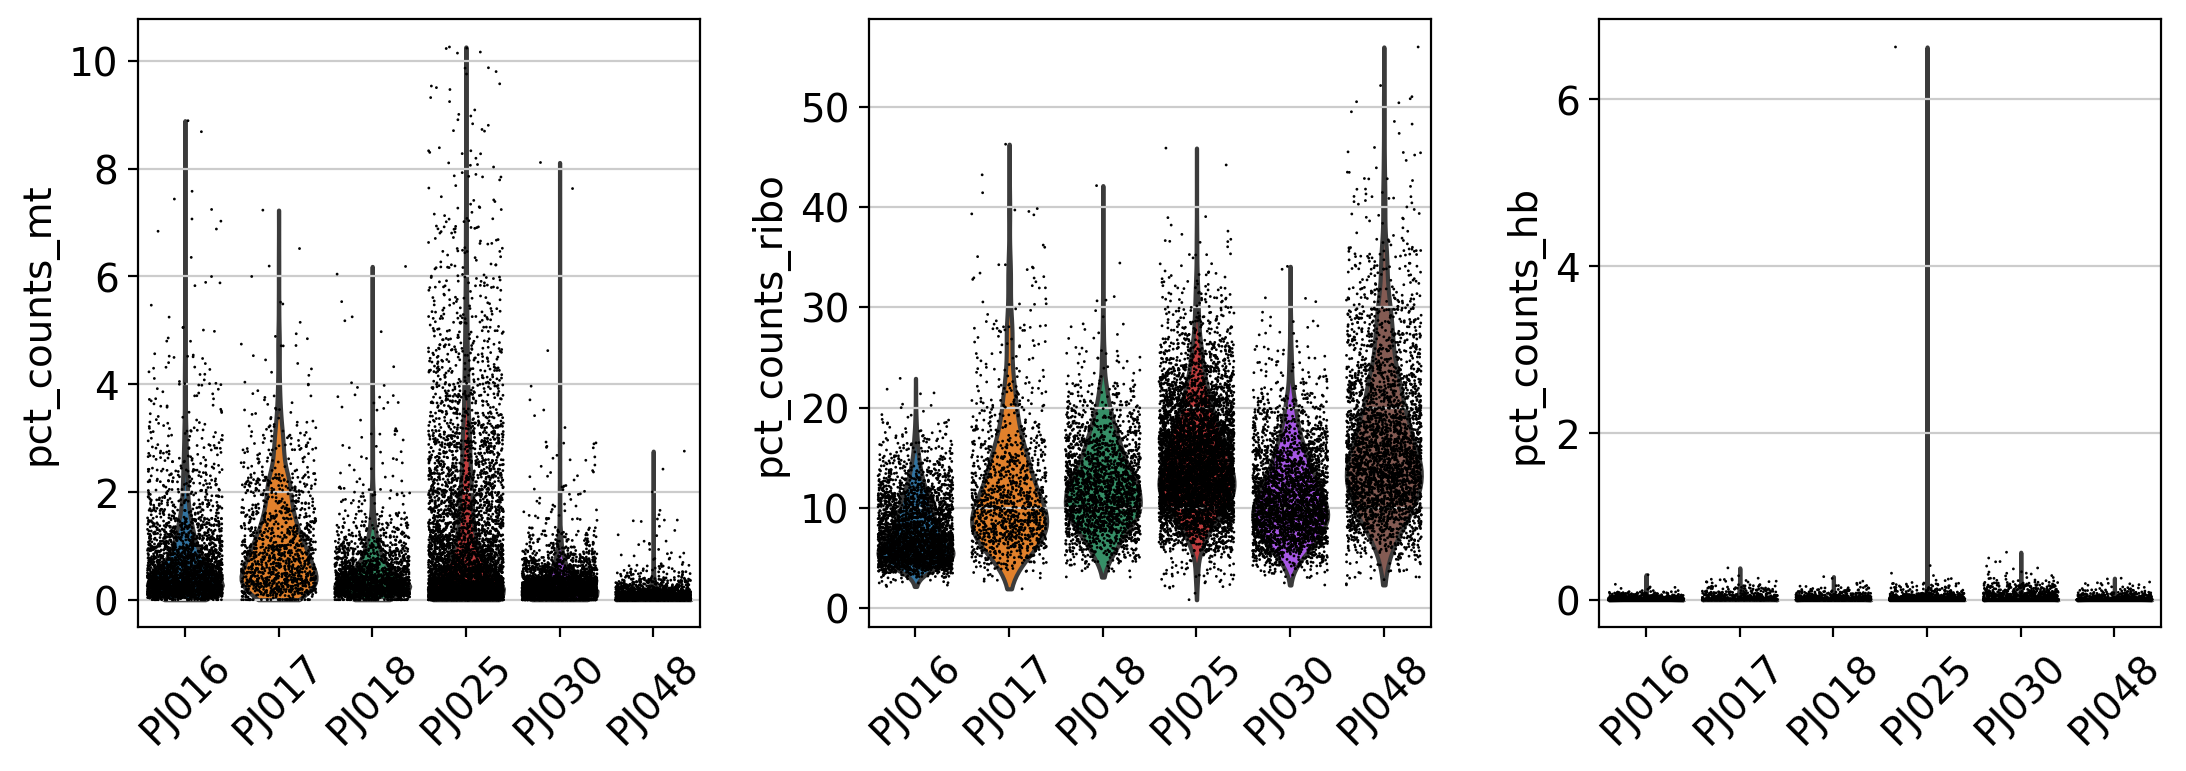

In [20]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

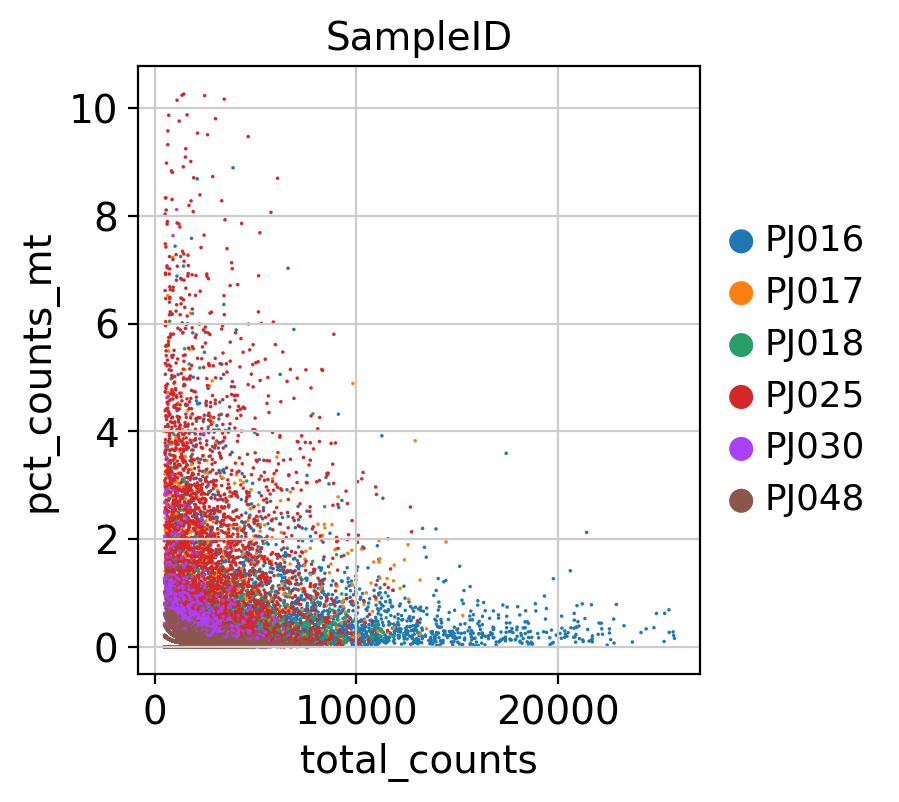

In [21]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [22]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

18648 31929


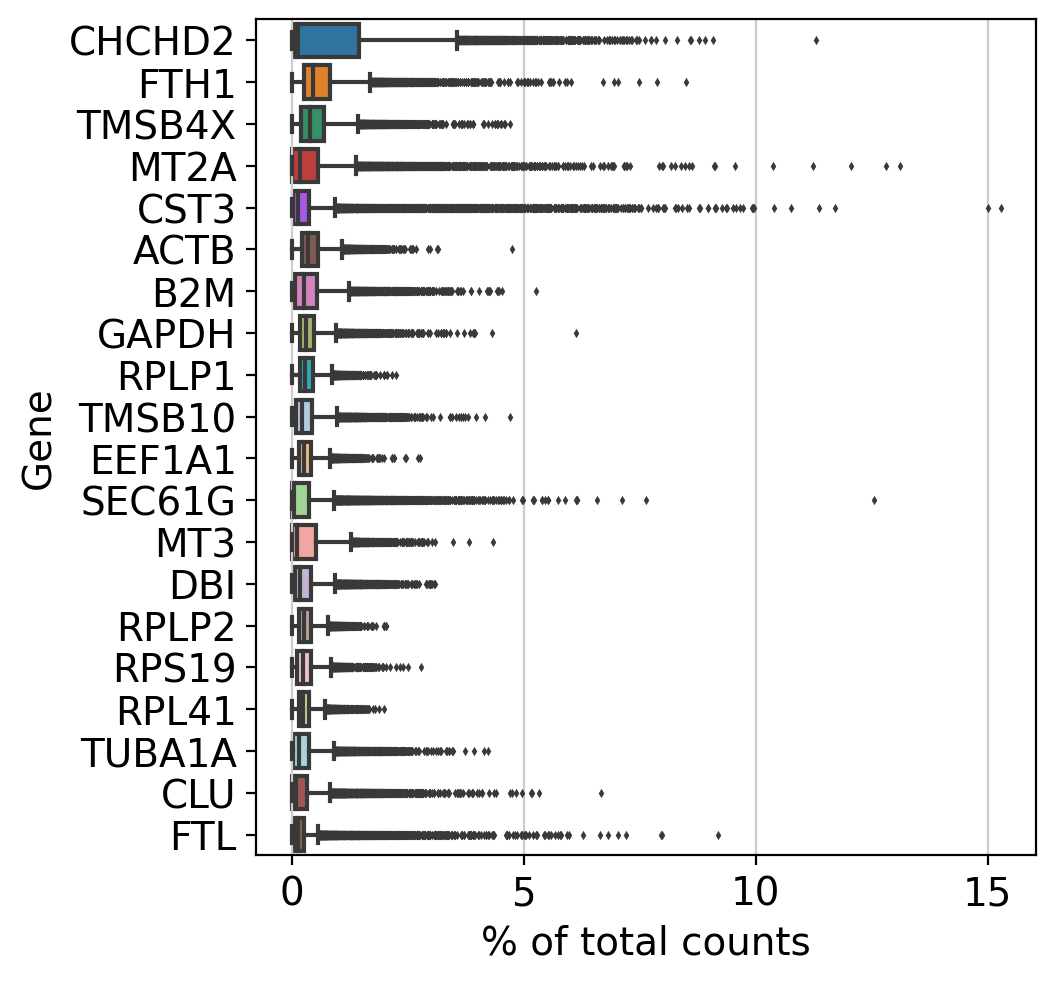

In [23]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Mito/Ribo filtering

In [ ]:
adata = adata[adata.obs['pct_counts_mt'] < 10, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 2, :]
adata = adata[adata.obs['pct_counts_hb'] < 2, :]
print("Remaining cells %d"%adata.n_obs)

# Plot filtered QC

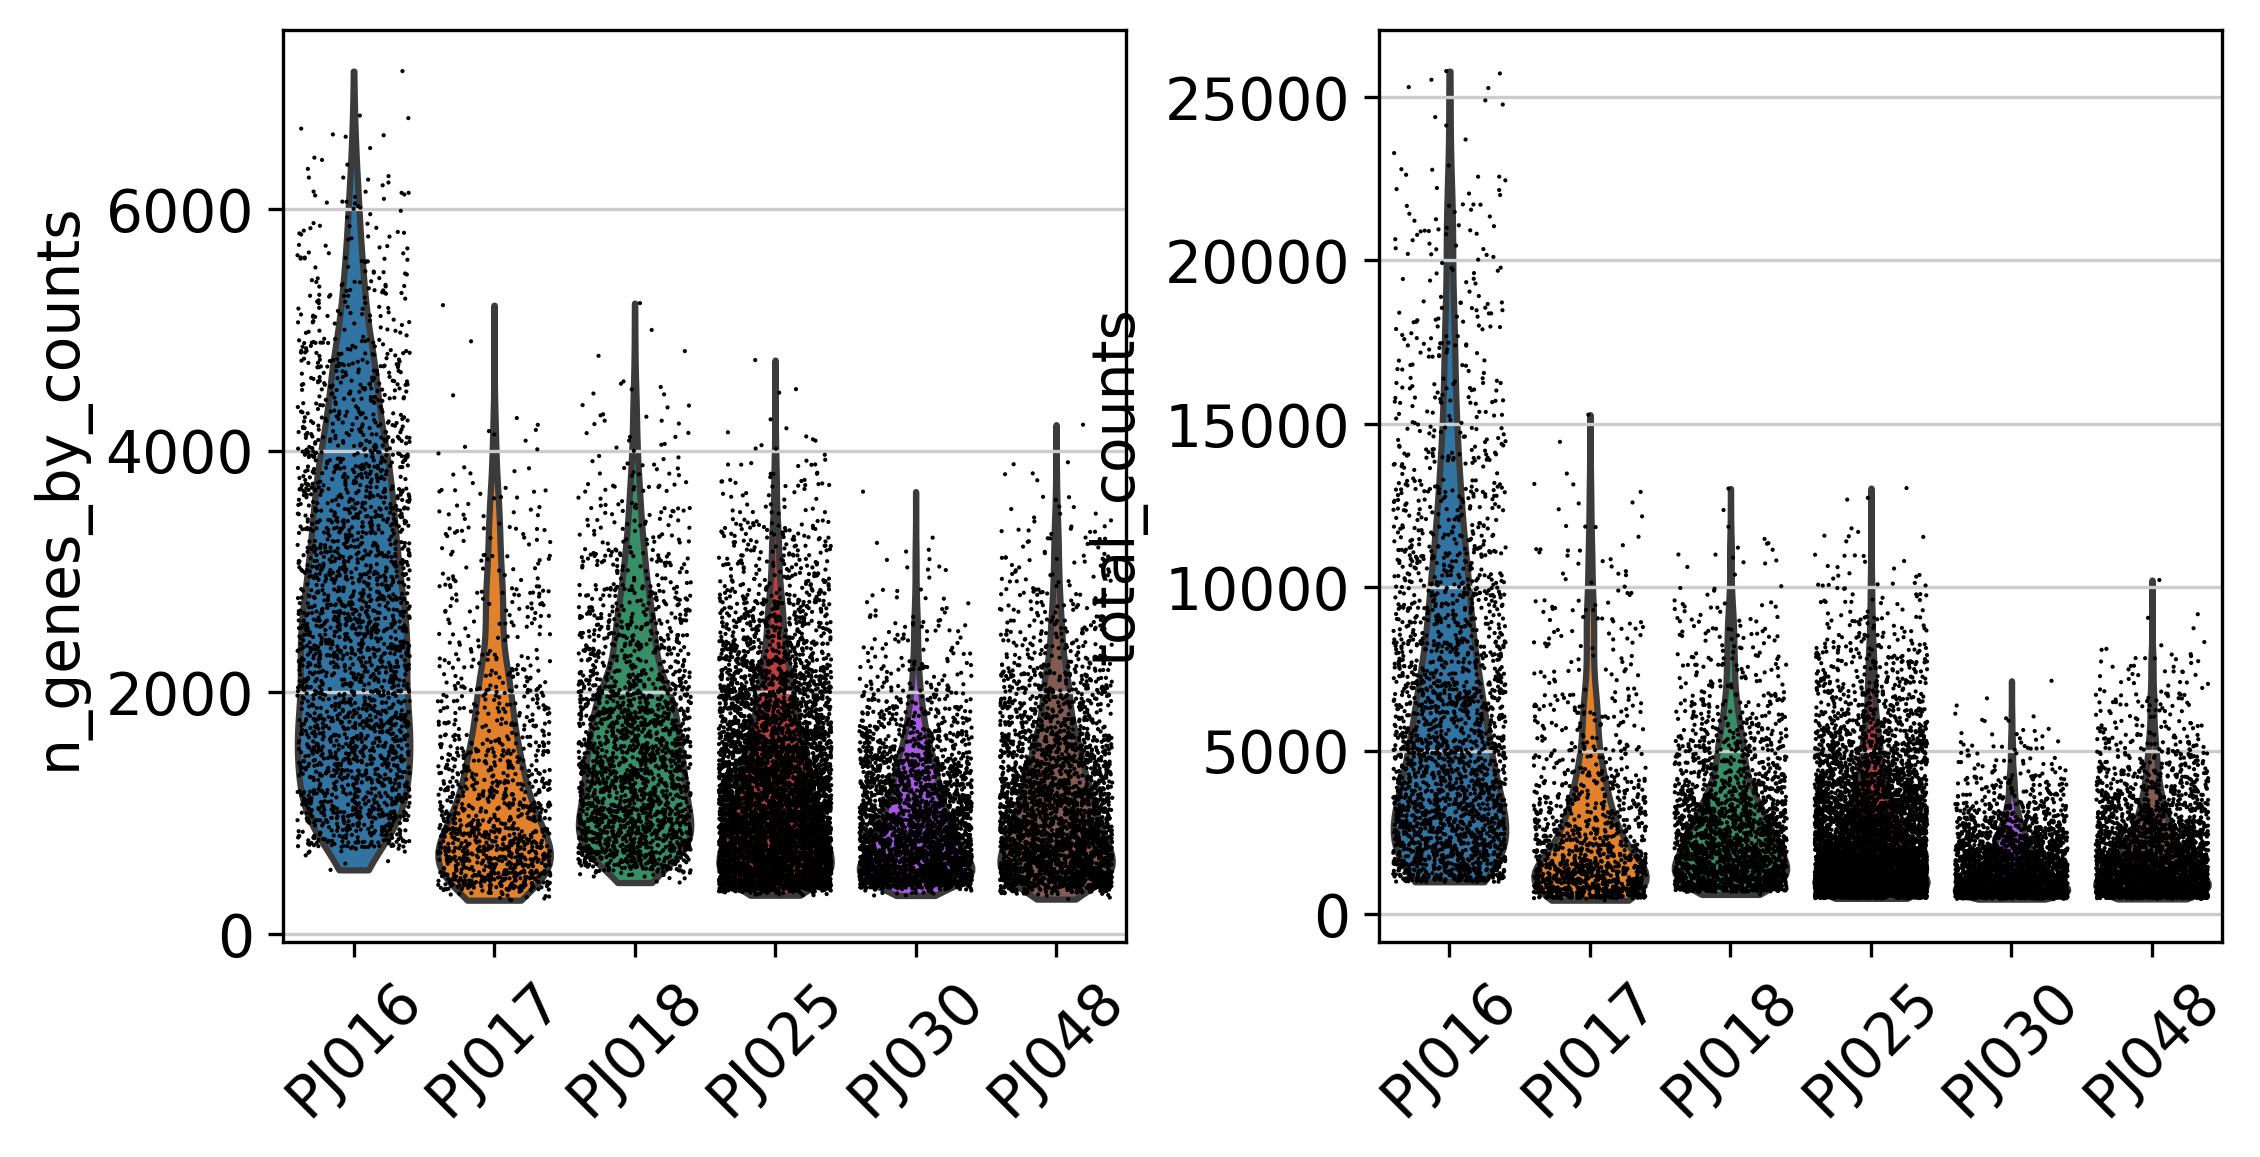

In [69]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

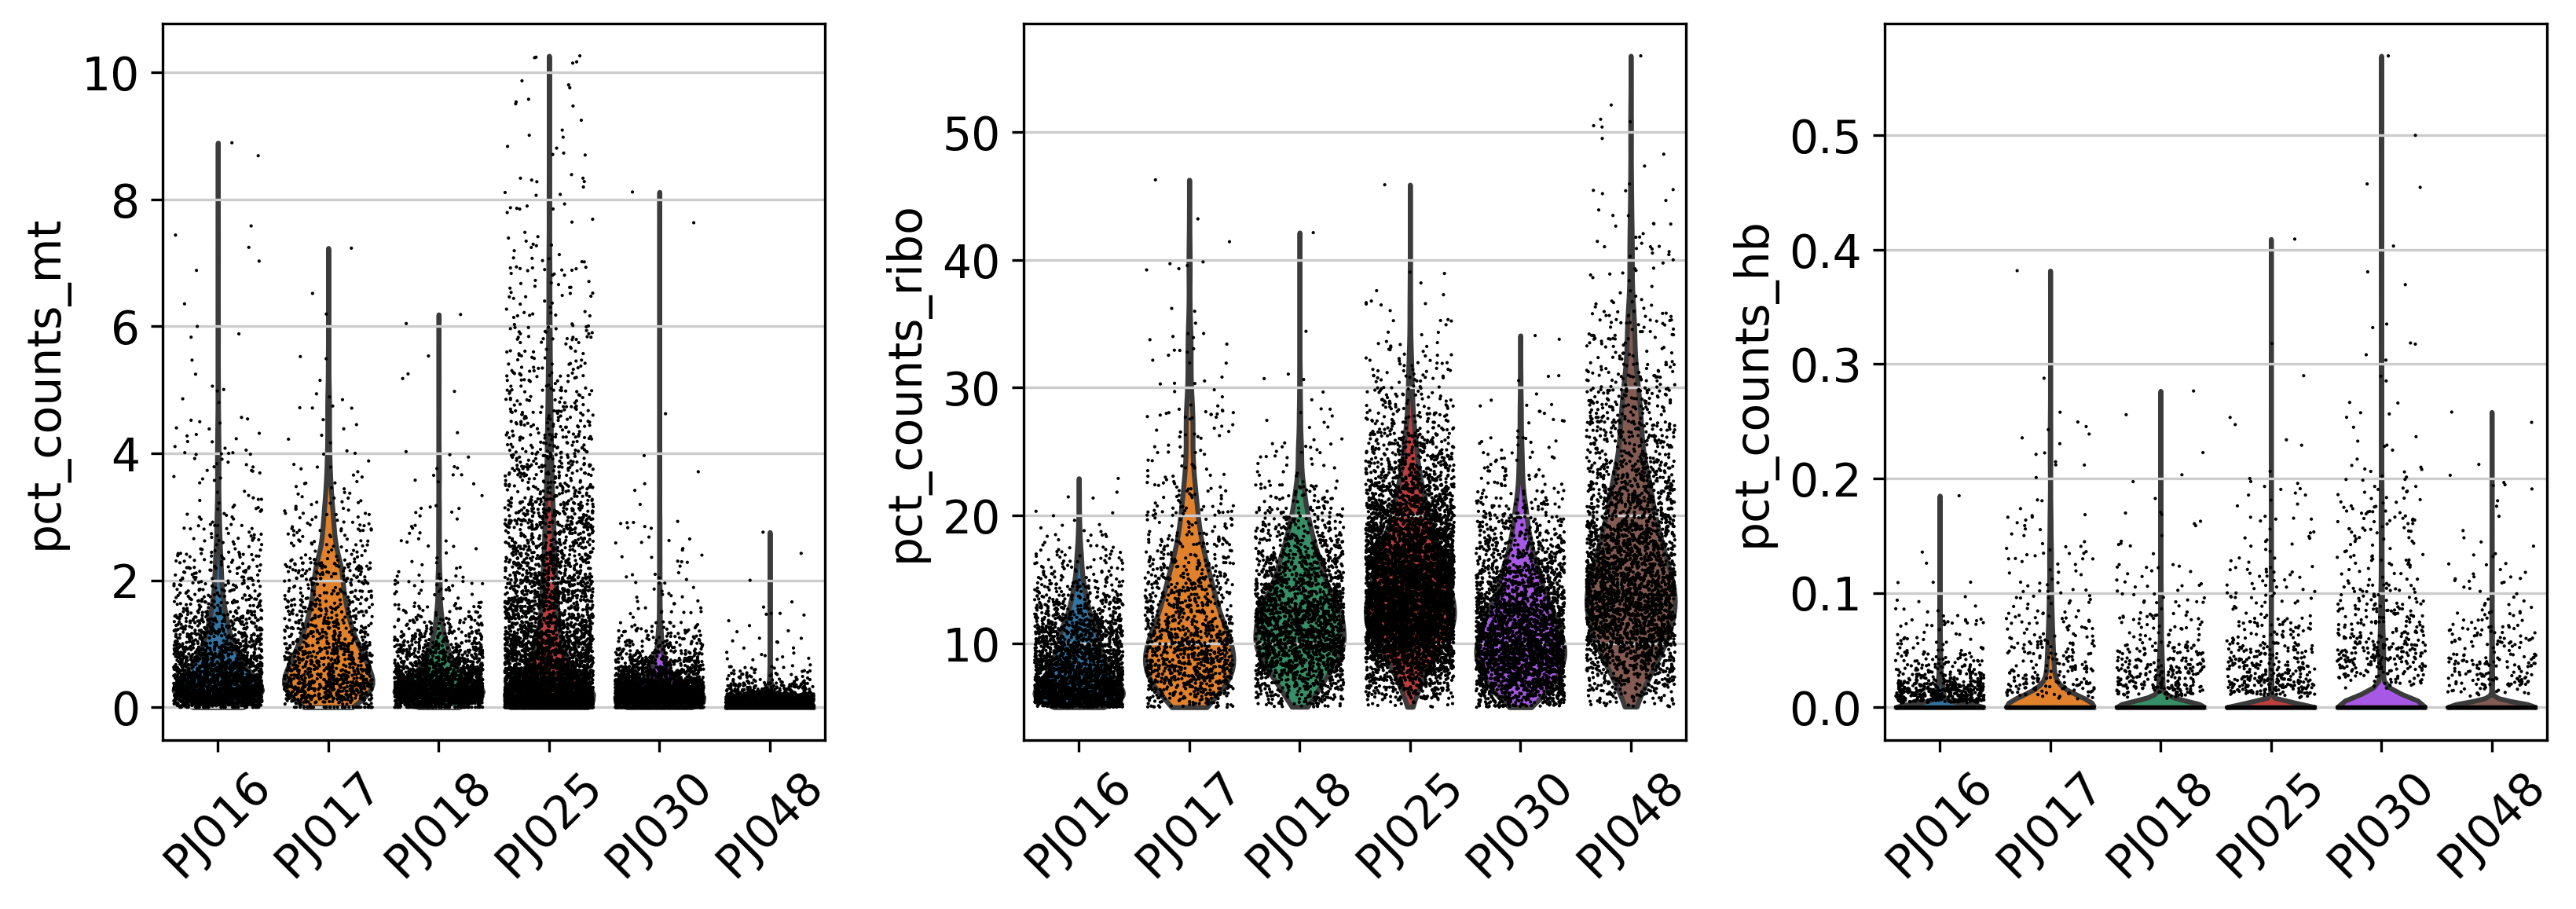

In [70]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

# Filter genes

In [ ]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [ ]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [29]:
adata = adata[:, ~mito_gene_indicator]

In [30]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

17779 31892
17779 30850


# Calculate cell-cycle scores

In [31]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]
print(len(cell_cycle_genes))
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

90
89


In [32]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


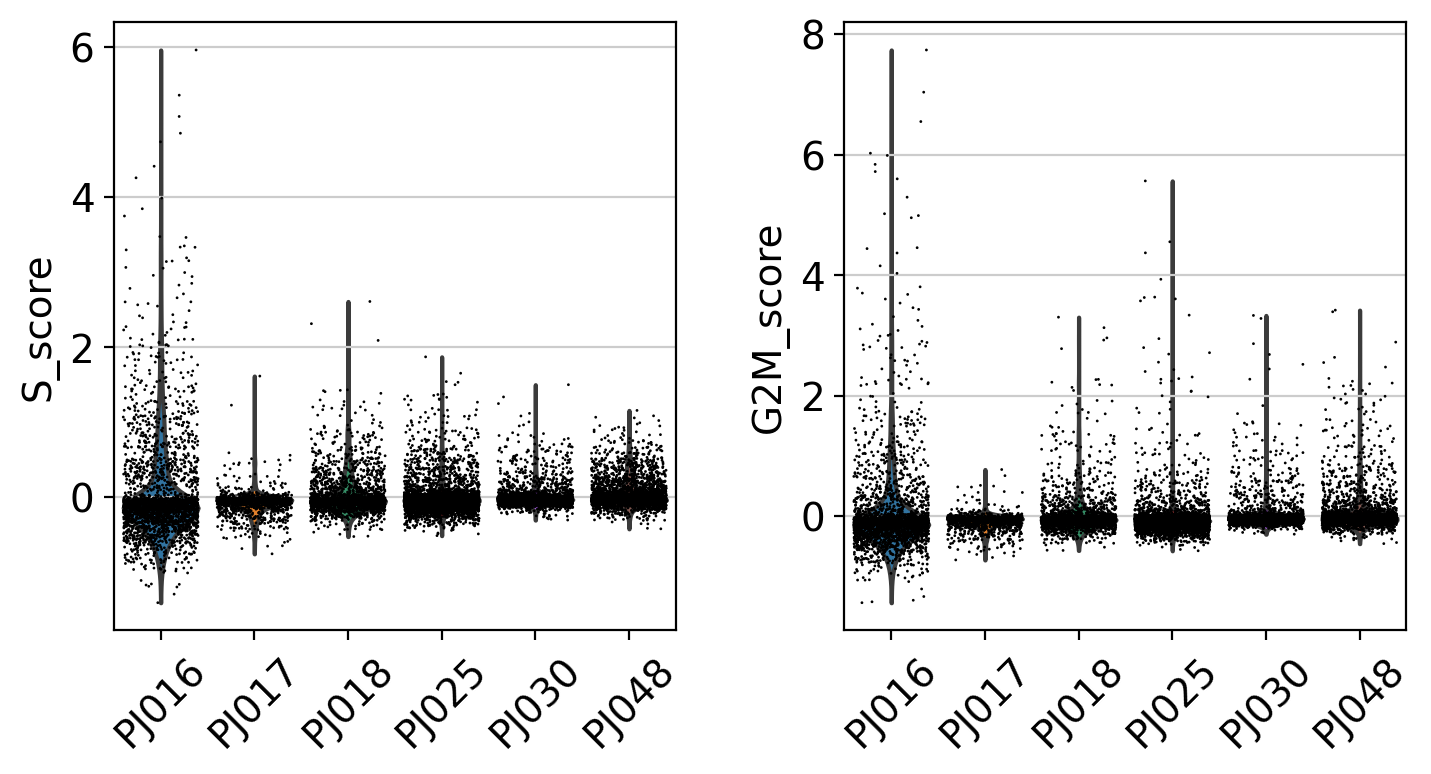

In [33]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'SampleID', rotation=45)

# Predict doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 16.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.0%
Elapsed time: 18.1 seconds


31

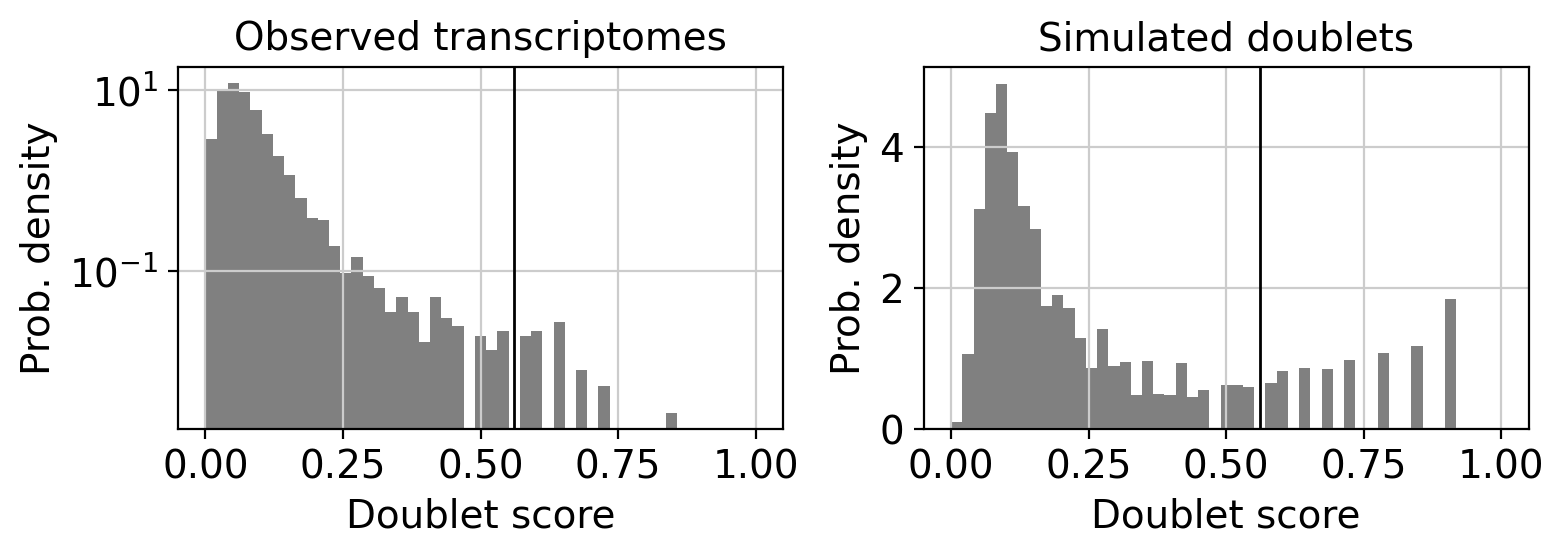

In [34]:
scrub = scr.Scrublet(adata.layers['raw'])
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [35]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


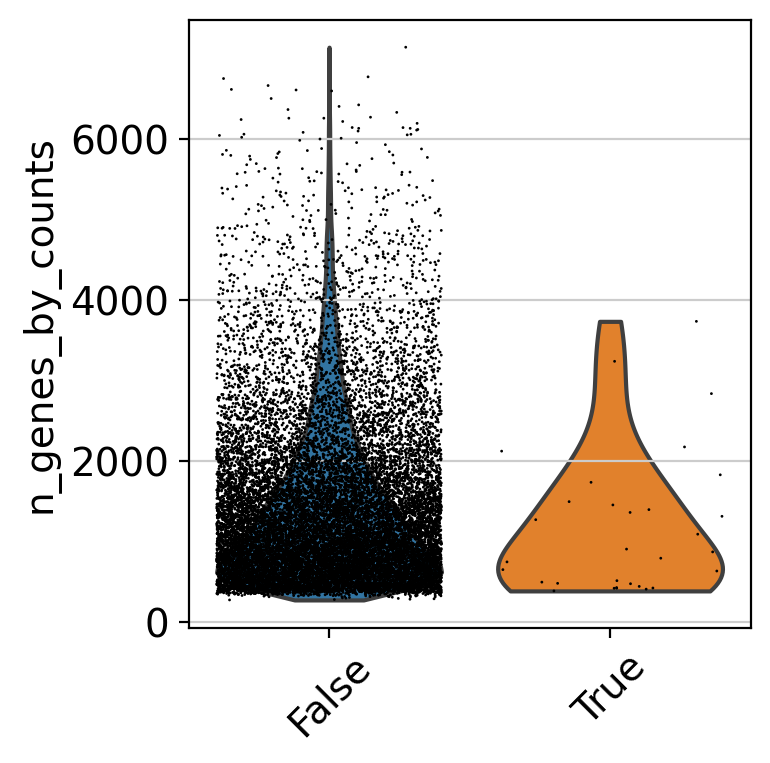

In [36]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'doublet_info', rotation=45)

In [37]:
adata = adata[adata.obs['doublet_info'] == "False",:]

# Processing 

In [38]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.
adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata

# scale
#sc.pp.scale(adata)

# Celltypist classification

In [39]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [40]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [41]:
sce.pp.harmony_integrate(adata, ['SampleID'])

2022-06-13 15:56:15,367 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-13 15:56:18,094 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-13 15:56:20,834 - harmonypy - INFO - Converged after 2 iterations
Converged after 2 iterations


In [42]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [43]:
sc.tl.umap(adata)

In [44]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [45]:
adata

AnnData object with n_obs × n_vars = 17748 × 30850
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 'distances', 'connectivities'

In [46]:
adata.X = adata.layers['raw']
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(adata)

In [47]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 13
📂 Storing models in /home/lugli/spuccio/.celltypist/data/models
💾 Downloading model [1/13]: Immune_All_Low.pkl
💾 Downloading model [2/13]: Immune_All_High.pkl
💾 Downloading model [3/13]: Immune_All_PIP.pkl
💾 Downloading model [4/13]: Immune_All_AddPIP.pkl
💾 Downloading model [5/13]: COVID19_Immune_Landscape.pkl
💾 Downloading model [6/13]: Cells_Fetal_Lung.pkl
💾 Downloading model [7/13]: Cells_Intestinal_Tract.pkl
💾 Downloading model [8/13]: Cells_Lung_Airway.pkl
💾 Downloading model [9/13]: Developing_Mouse_Brain.pkl
💾 Downloading model [10/13]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [11/13]: Human_Lung_Atlas.pkl
💾 Downloading model [12/13]: Nuclei_Lung_Airway.pkl
💾 Downloading model [13/13]: Pan_Fetal_Human.pkl


In [48]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [49]:
predictionsHigh = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 17748 cells and 30850 genes
🔗 Matching reference genes in the model
🧬 2683 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [50]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_A_GSE103224_PMID30041684.h5ad")

In [51]:
predictionsHigh.to_adata()

AnnData object with n_obs × n_vars = 17748 × 30850
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'lo

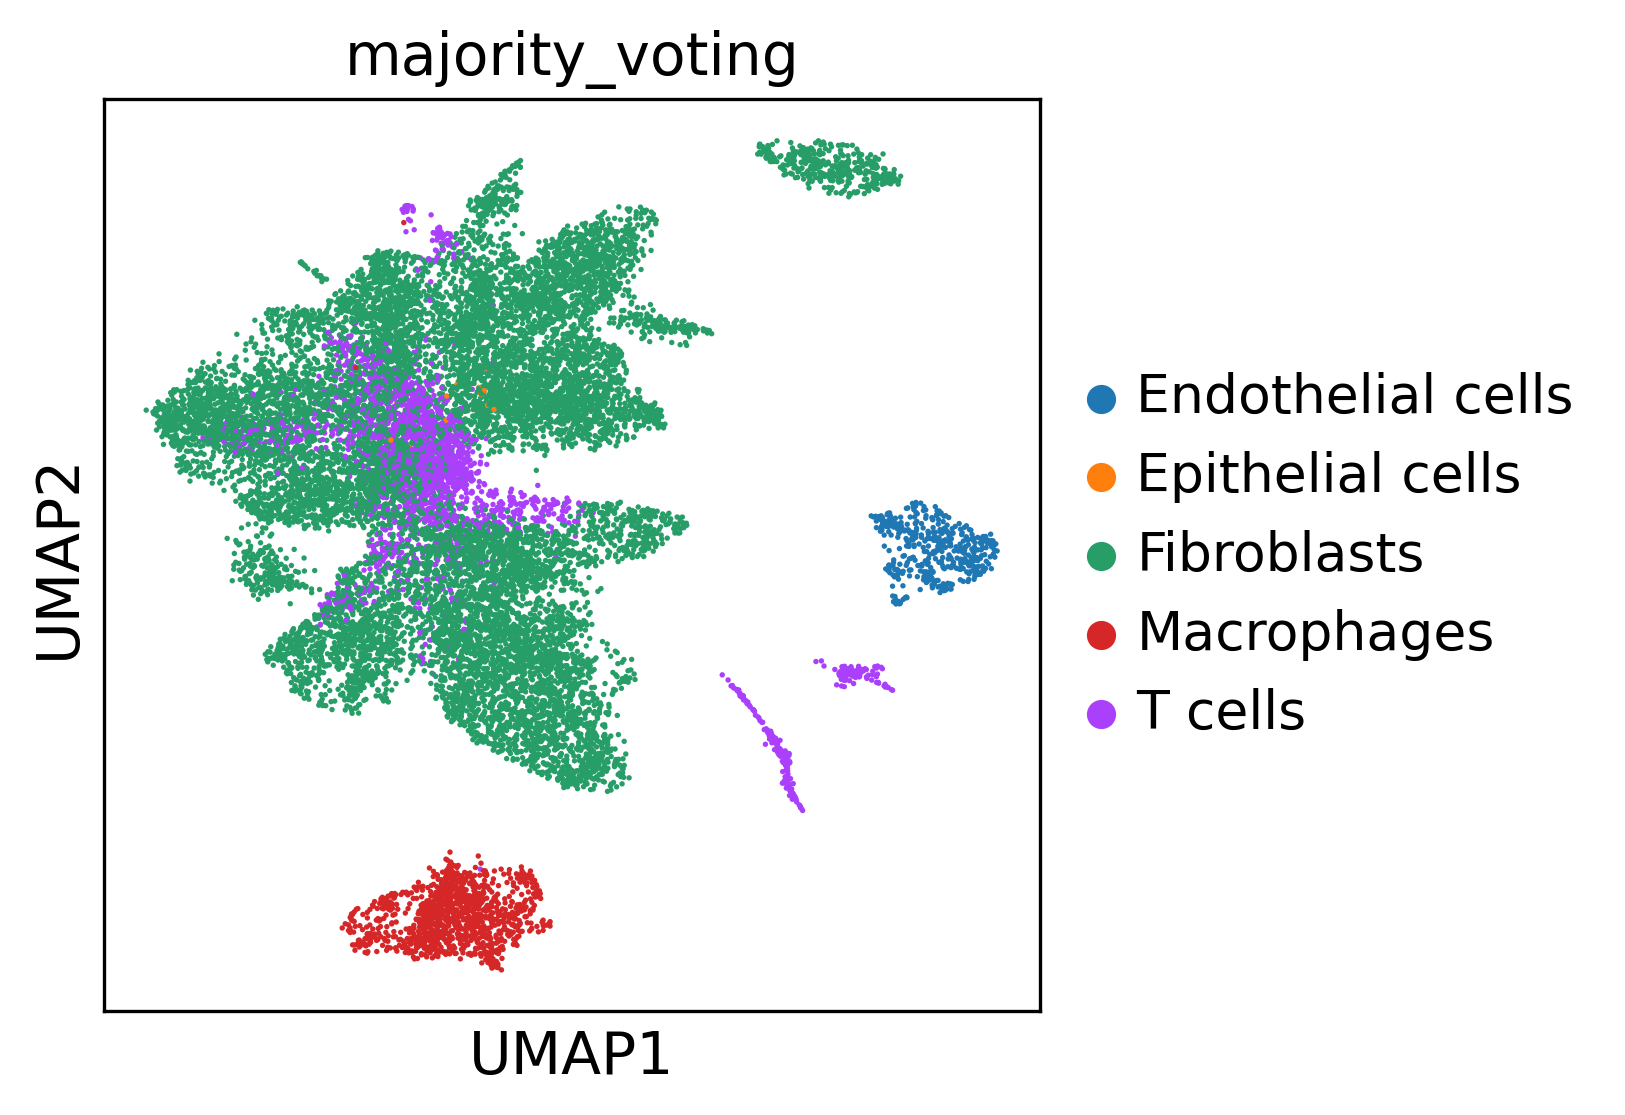

In [52]:
sc.set_figure_params(dpi=150)
sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting')


sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting', add_outline=True,
           legend_fontoutline=1,frameon=False,
               title='  ', palette='Paired_r',s=2)

# PangaDB classification

In [53]:
adata = adata[:, adata.var.highly_variable]

In [54]:
markers = dc.get_resource('PanglaoDB')
markers

label genesymbol canonical_marker         cell_type germ_layer human  \
0          CTRB1            False       Enterocytes   Endoderm  True   
1          CTRB1             True      Acinar cells   Endoderm  True   
2           KLK1             True      Acinar cells   Endoderm  True   
3           KLK1            False      Goblet cells   Endoderm  True   
4           KLK1            False  Epithelial cells   Mesoderm  True   
...          ...              ...               ...        ...   ...   
8472     SLC14A1             True  Urothelial cells   Mesoderm  True   
8473       UPK3A             True  Urothelial cells   Mesoderm  True   
8474       UPK1A             True  Urothelial cells   Mesoderm  True   
8475        UPK2             True  Urothelial cells   Mesoderm  True   
8476       UPK3B             True  Urothelial cells   Mesoderm  True   

label human_sensitivity human_specificity mouse mouse_sensitivity  \
0                   0.0        0.00439422  True        0.00331126   
1                   1.0       0.000628931  True          0.957143   
2              0.833333        0.00503145  True          0.314286   
3              0.588235        0.00503937  True          0.903226   
4                   0.0        0.00823306  True          0.225806   
...                 ...               ...   ...               ...   
8472                0.0         0.0181704  True               0.0   
8473                0.0               0.0  True               0.0   
8474                0.0               0.0  True               0.0   
8475                0.0               0.0  True               0.0   
8476                0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0             0.0204803        9606         GI tract           0.017  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
3             0.0124084        9606         GI tract           0.013  
4             0.0137585        9606       Epithelium           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[8477 rows x 13 columns]

In [55]:
markers['organ'].value_counts()

Immune system         1775
Brain                 1589
GI tract               540
Kidney                 450
Reproductive           429
Connective tissue      413
Vasculature            372
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        168
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                28
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: organ, dtype: int64

In [56]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label genesymbol canonical_marker                     cell_type germ_layer  \
1          CTRB1             True                  Acinar cells   Endoderm   
2           KLK1             True                  Acinar cells   Endoderm   
5           KLK1             True               Principal cells   Mesoderm   
7           KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
8           KLK1             True             Endothelial cells   Mesoderm   
...          ...              ...                           ...        ...   
8472     SLC14A1             True              Urothelial cells   Mesoderm   
8473       UPK3A             True              Urothelial cells   Mesoderm   
8474       UPK1A             True              Urothelial cells   Mesoderm   
8475        UPK2             True              Urothelial cells   Mesoderm   
8476       UPK3B             True              Urothelial cells   Mesoderm   

label human human_sensitivity human_specificity mouse mouse_sensitivity  \
1      True               1.0       0.000628931  True          0.957143   
2      True          0.833333        0.00503145  True          0.314286   
5      True               0.0        0.00814536  True          0.285714   
7      True               0.0        0.00820189  True               1.0   
8      True               0.0        0.00841969  True               0.0   
...     ...               ...               ...   ...               ...   
8472   True               0.0         0.0181704  True               0.0   
8473   True               0.0               0.0  True               0.0   
8474   True               0.0               0.0  True               0.0   
8475   True               0.0               0.0  True               0.0   
8476   True               0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
5             0.0140583        9606           Kidney           0.013  
7             0.0129136        9606    Immune system           0.013  
8             0.0149153        9606      Vasculature           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [57]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

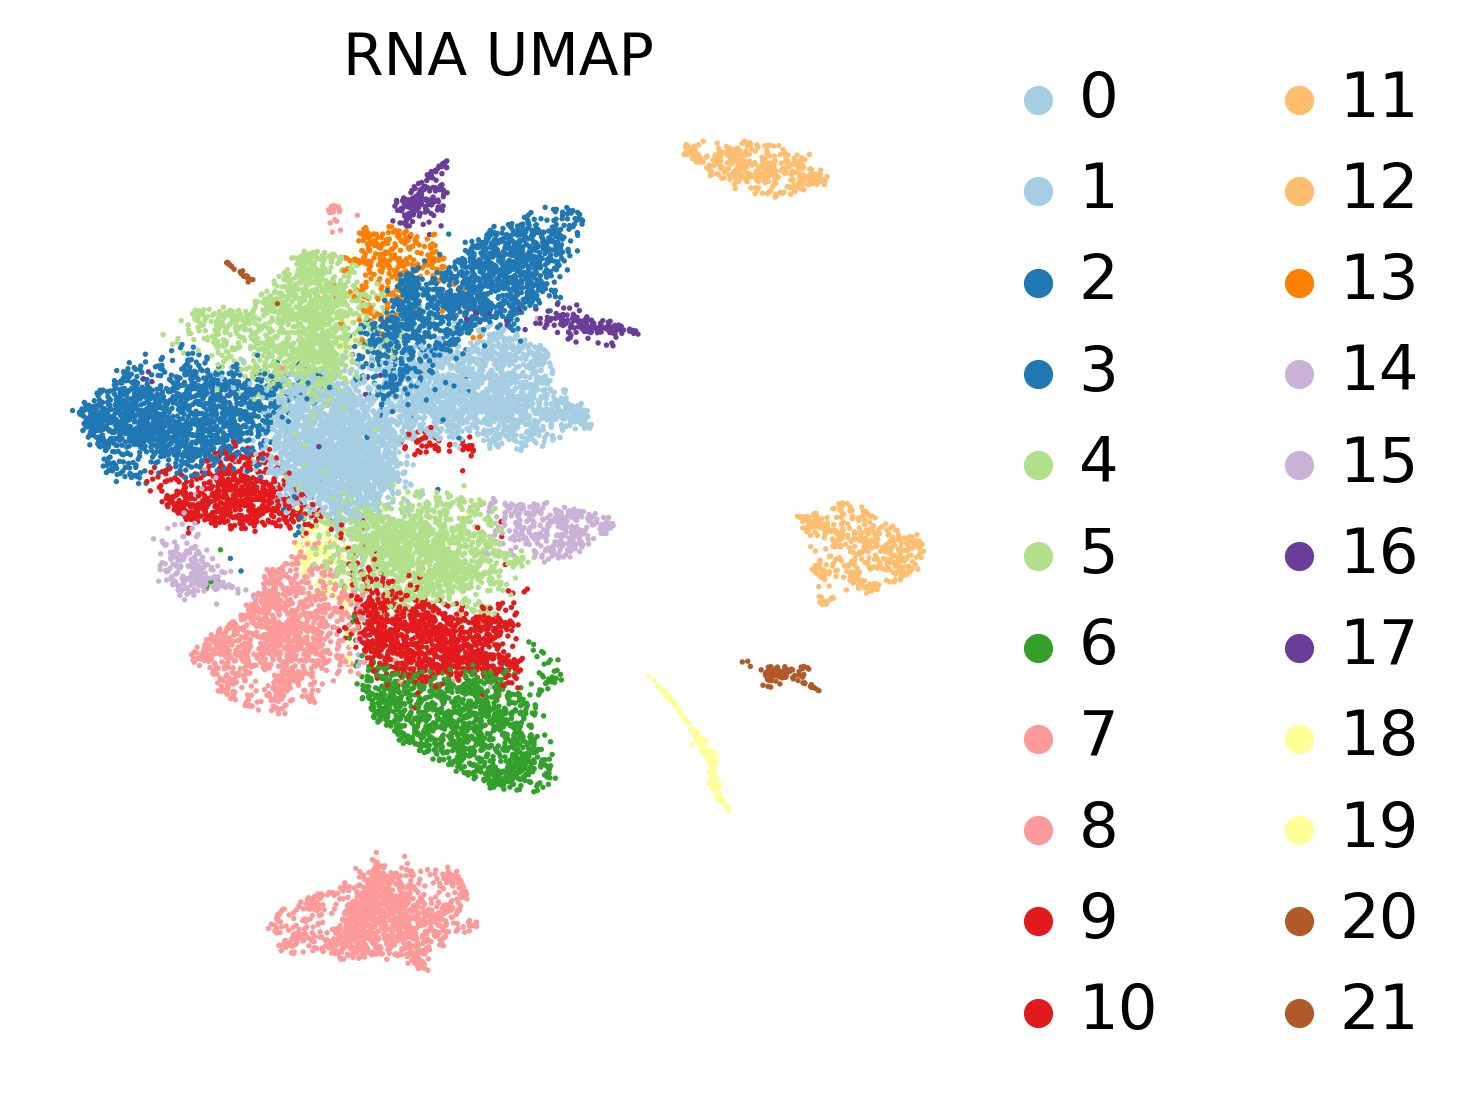

In [58]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [59]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 17748 samples and 4406 targets for 114 sources.


100%|██████████| 17748/17748 [00:06<00:00, 2683.91it/s]


In [60]:
adata.obsm['ora_estimate']

source      Acinar cells  Adipocytes  Airway goblet cells  Alpha cells  \
PJ048-0             -0.0   -0.000000                 -0.0    -0.000000   
PJ048-1             -0.0    1.070510                 -0.0     0.841310   
PJ048-2             -0.0    1.898393                 -0.0     1.994183   
PJ048-3             -0.0    0.412258                 -0.0     1.994183   
PJ048-4             -0.0   -0.000000                 -0.0     1.994183   
...                  ...         ...                  ...          ...   
PJ016-3080          -0.0   -0.000000                 -0.0    -0.000000   
PJ016-3081          -0.0    1.070510                 -0.0    -0.000000   
PJ016-3082          -0.0   -0.000000                 -0.0    -0.000000   
PJ016-3083          -0.0    0.412258                 -0.0    -0.000000   
PJ016-3084          -0.0   -0.000000                 -0.0    -0.000000   

source      Alveolar macrophages  Astrocytes   B cells  B cells memory  \
PJ048-0                -0.000000    -0.00000  1.781108       -0.000000   
PJ048-1                -0.000000     0.52372  0.741494       -0.000000   
PJ048-2                -0.000000     0.52372  1.781108       -0.000000   
PJ048-3                -0.000000     0.52372  1.781108        0.720335   
PJ048-4                -0.000000    -0.00000  0.741494       -0.000000   
...                          ...         ...       ...             ...   
PJ016-3080              1.267223    -0.00000  3.017365        1.735940   
PJ016-3081             -0.000000     0.52372 -0.000000        0.720335   
PJ016-3082             -0.000000    -0.00000  0.741494        0.720335   
PJ016-3083             -0.000000     0.52372 -0.000000        0.720335   
PJ016-3084             -0.000000    -0.00000 -0.000000        0.720335   

source      B cells naive  Basophils  ...  Sebocytes  Sertoli cells  \
PJ048-0         -0.000000  -0.000000  ...   -0.00000      -0.000000   
PJ048-1         -0.000000  -0.000000  ...   -0.00000       0.741494   
PJ048-2         -0.000000  -0.000000  ...    1.19042      -0.000000   
PJ048-3          0.681499   0.700375  ...   -0.00000       0.741494   
PJ048-4         -0.000000  -0.000000  ...   -0.00000      -0.000000   
...                   ...        ...  ...        ...            ...   
PJ016-3080       2.815810   1.693316  ...   -0.00000       0.741494   
PJ016-3081       0.681499   2.879223  ...   -0.00000       0.741494   
PJ016-3082       0.681499   0.700375  ...   -0.00000       0.741494   
PJ016-3083       0.681499   2.879223  ...   -0.00000       0.741494   
PJ016-3084       0.681499   1.693316  ...   -0.00000       0.741494   

source      Smooth muscle cells    T cells  T helper cells  \
PJ048-0               -0.000000  -0.000000       -0.000000   
PJ048-1                0.412258   0.491571       -0.000000   
PJ048-2                0.412258  -0.000000       -0.000000   
PJ048-3                0.412258   0.491571       -0.000000   
PJ048-4                0.412258  -0.000000       -0.000000   
...                         ...        ...             ...   
PJ016-3080             0.412258  11.495944        2.287390   
PJ016-3081             0.412258   0.491571        0.978039   
PJ016-3082             1.070510   0.491571        0.978039   
PJ016-3083             0.412258   0.491571        0.978039   
PJ016-3084             1.070510   0.491571        0.978039   

source      T regulatory cells  Tanycytes  Taste receptor cells  Thymocytes  \
PJ048-0                   -0.0  -0.000000                  -0.0   -0.000000   
PJ048-1                   -0.0   2.381138                  -0.0   -0.000000   
PJ048-2                   -0.0   1.021436                  -0.0   -0.000000   
PJ048-3                   -0.0   1.021436                  -0.0   -0.000000   
PJ048-4                   -0.0   2.381138                  -0.0   -0.000000   
...                        ...        ...                   ...         ...   
PJ016-3080                -0.0  -0.000000                  -0.0    2.28

In [61]:
adata.obsm['ora_estimate'].columns

Index(['Acinar cells', 'Adipocytes', 'Airway goblet cells', 'Alpha cells',
       'Alveolar macrophages', 'Astrocytes', 'B cells', 'B cells memory',
       'B cells naive', 'Basophils',
       ...
       'Sebocytes', 'Sertoli cells', 'Smooth muscle cells', 'T cells',
       'T helper cells', 'T regulatory cells', 'Tanycytes',
       'Taste receptor cells', 'Thymocytes', 'Tuft cells'],
      dtype='object', name='source', length=114)

In [62]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 17748 × 114
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [63]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

Astrocytes  Bergmann glia  Dendritic cells  Endothelial cells  \
0     1.348106       3.184302         1.512297           6.053030   
1     7.641338       7.713874         1.421884           6.364810   
10    4.145643       5.456576         1.109051           4.735777   
11    1.028057       3.438627         1.665035          30.654861   
12    0.860176       3.096160         1.768352           9.870197   
13    3.191296       5.867315         4.973012           7.619540   
14    1.302443       1.635289         1.061704           4.285995   
15    3.806717       5.288070         1.792710           4.044404   
16    2.208658       3.694899         1.545655           6.627176   
17    3.736623       5.549726         3.033095           5.105959   
18    1.153939       1.651686         1.108610           6.348945   
19    0.421622       1.341453         1.050737           4.513429   
2     4.889112       6.529632         1.856814           4.710710   
20    0.840307       1.581834         4.088763           4.834289   
21    0.719288       1.689241         1.975079           9.566157   
3     2.539100       3.000921         1.302858           7.144190   
4     1.088152       1.880258         0.828495           3.939671   
5     1.833301       3.357984         1.551377           5.037910   
6     1.663196       2.622009         0.882802           3.395454   
7     0.822761       2.050745        17.348812           4.042966   
8     0.478018       1.398087         0.730725           2.880996   
9     1.069230       2.115410         0.794712           3.620666   

    Fibroblasts  Gamma delta T cells  Glomus cells  Hematopoietic stem cells  \
0      2.139410             0.811785      1.324363                  0.852989   
1      3.845650             0.885065      1.550969                  1.223879   
10     3.693476             1.095845      0.879471                  1.526515   
11     8.823249             0.894565      2.465540                  5.667301   
12    14.765483             1.589688      5.286380                  2.183993   
13    11.473744             0.851661      3.135714                  2.520963   
14     2.857173             2.236097      0.809335                  1.071840   
15     4.459313             7.835848      1.242826                  1.211113   
16     4.939738             1.966350      1.744338                  1.428478   
17     4.536663             2.091931      1.493051                  1.161668   
18     3.185077             1.540990      0.674872                  1.334612   
19     1.691172             1.550128      1.192734                  1.062048   
2      4.518913             1.853501      1.393388                  1.155369   
20     3.288469             4.029855      0.608938                  2.581232   
21    20.605343             1.878400      1.888133                  1.935055   
3      6.283267             2.458230      1.445213                  1.736824   
4      2.269731             1.784883      0.985501                  1.166090   
5      5.137712             1.088542      1.851053                  1.415492   
6      2.518418            11.018022      1.002350                  1.113445   
7      4.844163             0.529711      0.310788                  2.372595   
8      1.589726             1.941334      1.245434                  1.016316   
9      2.220439             6.483746      0.963085                  1.082738   

    Hepatic stellate cells  Kupffer cells  ...  Neutrophils  \
0                 1.999543       1.919731  ...     0.555674   
1                 3.007449       1.794442  ...     0.506362   
10                2.246368       1.646439  ...     0.477319   
11                5.208845       0.832447  ...     0.678328   
12               12.781466       1.331289  ...     0.447346   
13                4.792058       0.980486  ...     1.368081   
14                1.227760       1.115831  ...     0.405757   
15                3.354867       0.772525  ...     0.131686   
16      

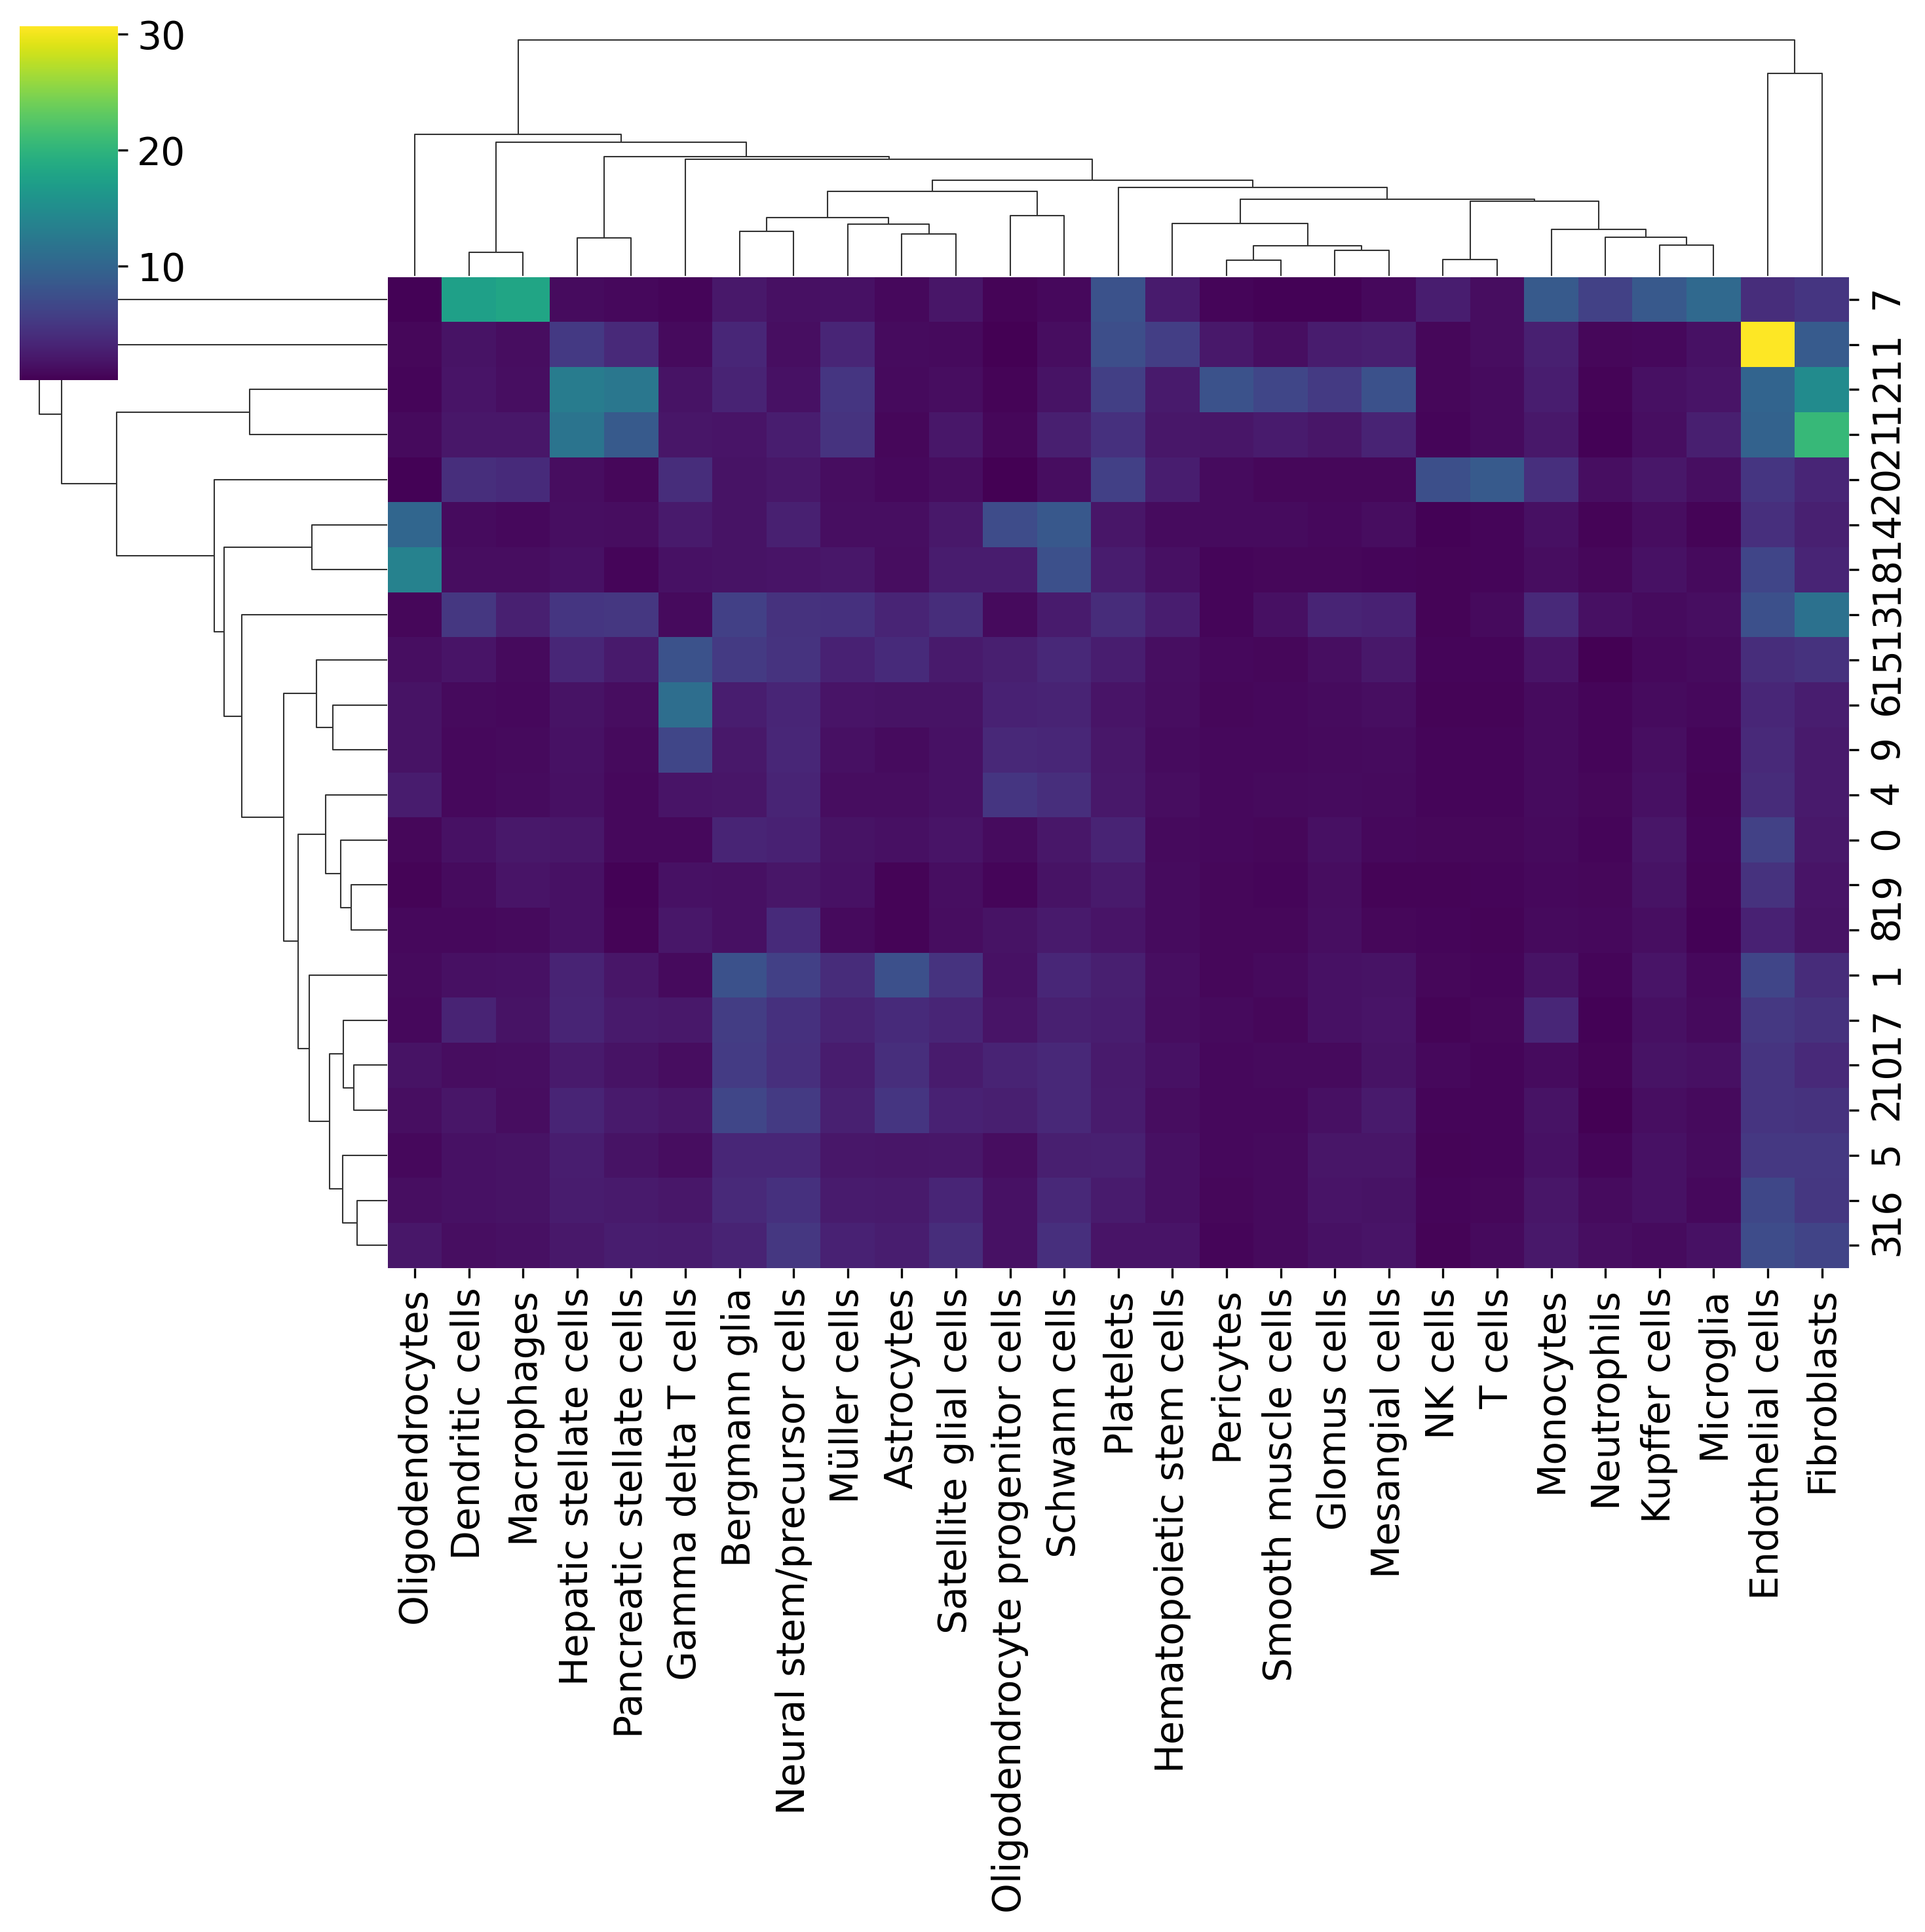

In [64]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [65]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'Endothelial cells',
 '1': 'Bergmann glia',
 '10': 'Bergmann glia',
 '11': 'Endothelial cells',
 '12': 'Fibroblasts',
 '13': 'Fibroblasts',
 '14': 'Oligodendrocytes',
 '15': 'Gamma delta T cells',
 '16': 'Endothelial cells',
 '17': 'Bergmann glia',
 '18': 'Oligodendrocytes',
 '19': 'Endothelial cells',
 '2': 'Bergmann glia',
 '20': 'T cells',
 '21': 'Fibroblasts',
 '3': 'Endothelial cells',
 '4': 'Oligodendrocyte progenitor cells',
 '5': 'Fibroblasts',
 '6': 'Gamma delta T cells',
 '7': 'Macrophages',
 '8': 'Neural stem/precursor cells',
 '9': 'Gamma delta T cells'}

... storing 'cell_type' as categorical


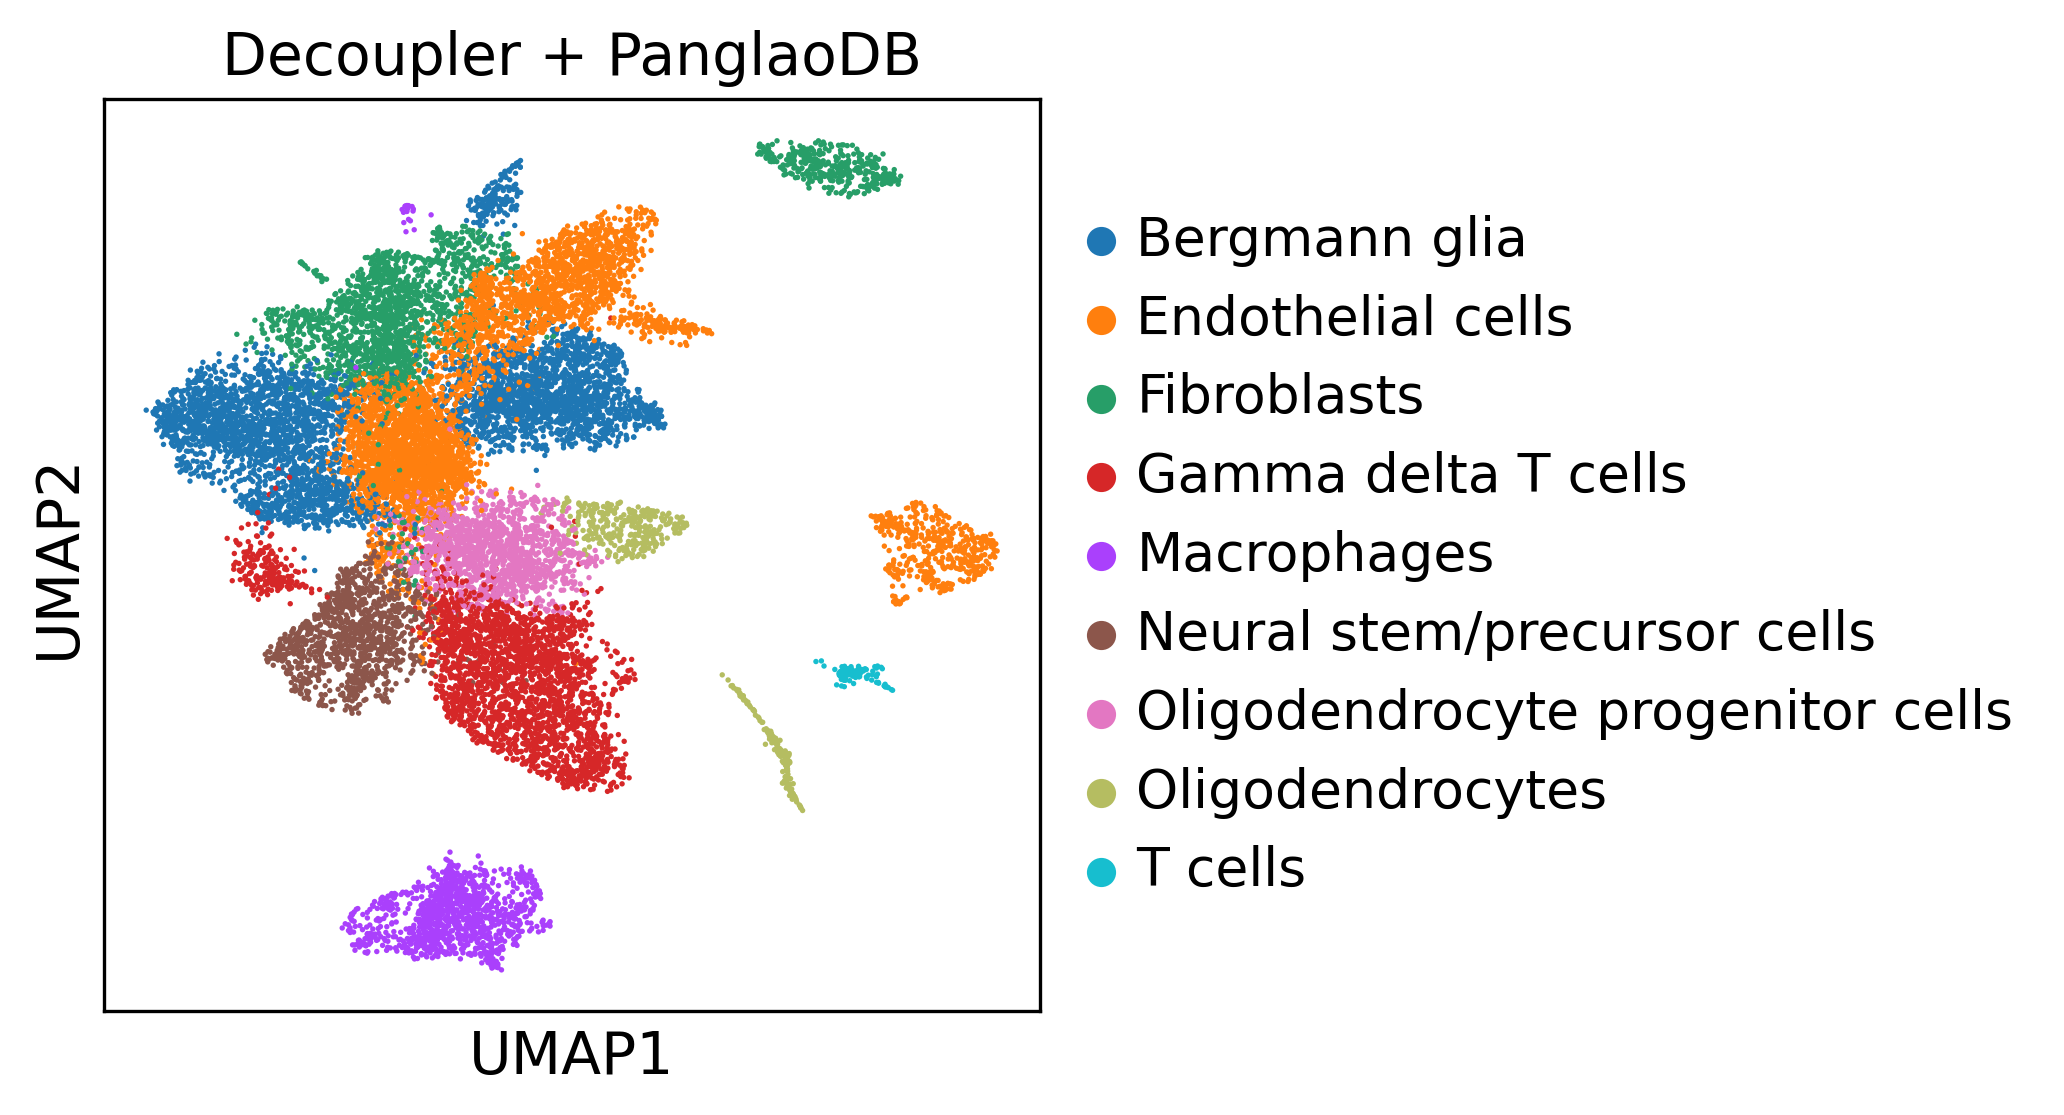

In [66]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [67]:
adata

AnnData object with n_obs × n_vars = 17748 × 4406
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'SampleID_colors', 'doublet_info_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'majority_voting_colors', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_p

In [68]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_A_GSE103224_PMID30041684.h5ad")